# Lib import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

# Скачивание предобработанного датасета

Загружаем датасет с GitHub:

In [2]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-05-13 11:19:07--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-05-13 11:19:07--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  13.59M  7.91MB/s    in 1.7s    

2023-05-13 11:19:09 (7.91 MB/s) - ‘/tmp/data.zip’ saved [14249699]



In [3]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


Исправление неопознанного бага с символом `s` в столбце `M1 TED (W)`:

In [4]:
import string

for row_index in range(0, df.shape[0]):
    for char in list(string.ascii_lowercase):
        if type(df.iloc[row_index]) == str:
            if char in df.iloc[row_index, 17]:
                df.iloc[row_index, 17] = df.iloc[row_index, 17][1:]
                print('Gotcha, damn bug!')
            else:
                print("What the hell?")

# Распределение входных параметров во всем датасете

Сократим датасет до нужных нам параметров:

In [5]:
#df_sorted = df.sort_values(by='Beam length (um)', axis=0, ascending=True)

In [6]:
#pd.set_option('display.max_rows', 100)
#df_sorted.iloc[4400:4500, :]

In [7]:
def reduce_df(df, param_general, param_save, mode_number):
    # general parameters - параметры, одинаковые для всех мод колебаний
    # parameters_to_use - параметры, которые мы хотим оставить
    # mode_number - число мод в датасете
    columns_to_get = []
    for mode_index in range(1, mode_number + 1):
        for parameter in param_save:
            columns_to_get.append(f'M{mode_index} ' + parameter)
    param_general += columns_to_get
    return df[param_general]

In [8]:
param_general = ['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)', 'Pretension (Pa)']
param_save = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']
#df = reduce_df(df, param_general=param_general, param_save=param_save, mode_number=4)
df.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


In [9]:
pd.set_option('display.max_columns', 30)
df.describe()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03
mean,195.469415,529.097516,150.819856,30.404340,23.742353,349.708484,17.227796,4.712346e+08,6.988914e+06,2.502643e+07,2.791775e-14,3.284923e-24,3.305690e-12,1.615011e+07,2.361783e+07,2.804072e-14,1.034791e-23,5.672434e-12,2.804685e+07,2.219908e+07,2.808115e-14,2.014207e-23,7.943504e-12,4.173375e+07,2.115728e+07,2.806848e-14,1.691331e-23,1.017113e-11
std,238.666890,269.281493,41.982835,11.712403,49.683629,145.560699,12.786909,3.190863e+08,1.098401e+07,8.329148e+07,4.391482e-14,6.621312e-23,3.466074e-12,2.737145e+07,7.749636e+07,4.388120e-14,2.047638e-22,5.494667e-12,5.009151e+07,7.344745e+07,4.388424e-14,3.843014e-22,7.561086e-12,7.418109e+07,8.666440e+07,4.391170e-14,2.545723e-22,9.704030e-12
min,10.006357,50.114701,66.096716,10.055810,0.010004,100.222269,0.000000,0.000000e+00,3.840254e+04,1.409866e+03,1.256945e-16,2.932070e-34,1.988965e-15,7.683005e+04,1.409860e+03,1.259756e-16,5.865251e-34,1.153546e-14,1.153109e+05,1.409853e+03,1.263636e-16,8.801085e-34,3.347321e-14,1.538710e+05,1.409842e+03,1.266484e-16,9.123322e-34,7.378453e-14
25%,36.605352,298.766024,107.242205,20.117549,0.309281,220.216016,5.140889,2.366180e+08,8.730700e+05,2.943045e+05,3.492639e-15,3.192913e-30,6.014538e-13,1.757714e+06,2.769933e+05,3.623304e-15,6.930178e-30,1.884886e-12,2.650417e+06,2.537637e+05,3.638416e-15,1.125043e-29,2.898015e-12,3.557429e+06,2.296537e+05,3.614451e-15,1.998218e-29,3.819665e-12
50%,97.149246,526.461810,150.537470,30.610468,2.657895,349.938323,17.005210,4.777992e+08,2.470389e+06,1.872628e+06,1.032800e-14,2.484688e-28,2.331108e-12,5.041691e+06,1.768129e+06,1.055878e-14,5.438185e-28,4.082376e-12,7.744980e+06,1.620164e+06,1.061271e-14,9.200261e-28,5.521390e-12,1.059702e+07,1.356222e+06,1.062533e-14,1.503564e-27,7.042181e-12
75%,257.772109,758.297463,193.682337,40.815722,19.179475,476.299101,28.608417,7.477595e+08,7.668586e+06,1.221293e+07,3.247702e-14,1.347538e-26,4.843418e-12,1.652162e+07,1.165410e+07,3.256713e-14,3.186328e-26,7.780666e-12,2.693589e+07,1.071371e+07,3.272321e-14,5.545136e-26,1.055391e-11,3.932619e+07,9.048577e+06,3.280904e-14,8.259448e-26,1.334680e-11
max,1195.787212,999.773967,234.883842,49.992126,299.880837,599.954225,39.995581,9.994946e+08,8.115660e+07,1.467439e+09,4.326970e-13,3.484406e-21,3.974018e-11,2.038823e+08,1.339585e+09,4.327339e-13,1.062324e-20,6.391638e-11,3.675392e+08,1.207506e+09,4.327311e-13,1.952995e-20,7.927833e-11,4.399336e+08,2.734598e+09,4.327028e-13,9.359624e-21,1.112834e-10


Вытаскиваем все названия колонок входных параметров:

In [10]:
col_names = list(df.columns)
print(col_names)

['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)', 'Pretension (Pa)', 'M1 Eigenfrequency (Hz)', 'M1 Quality factor', 'M1 Effective mass (kg)', 'M1 TED (W)', 'M1 Noise (kg^2/s^3)', 'M2 Eigenfrequency (Hz)', 'M2 Quality factor', 'M2 Effective mass (kg)', 'M2 TED (W)', 'M2 Noise (kg^2/s^3)', 'M3 Eigenfrequency (Hz)', 'M3 Quality factor', 'M3 Effective mass (kg)', 'M3 TED (W)', 'M3 Noise (kg^2/s^3)', 'M4 Eigenfrequency (Hz)', 'M4 Quality factor', 'M4 Effective mass (kg)', 'M4 TED (W)', 'M4 Noise (kg^2/s^3)']


Функция для визуализации распределений:

In [11]:
def plot_distribution(df, indices_to_plot: list, col_names, log_scale):
    fig, ax = plt.subplots(nrows=1, ncols=len(indices_to_plot), figsize=(5 * len(indices_to_plot), 5))
    for j in range(0, len(indices_to_plot)):
        sns.histplot(df.iloc[:, indices_to_plot[j]], ax=ax[j], log_scale=log_scale[j])
        ax[j].set_title(f"{col_names[indices_to_plot[j]]} distribution.", fontsize=2 * (len(indices_to_plot) + 1))
        ax[j].set_xlabel(col_names[indices_to_plot[j]])
        ax[j].set_ylabel('Count')
    plt.show()

Распределение длины, ширины и толщин нанопровода в датасете:

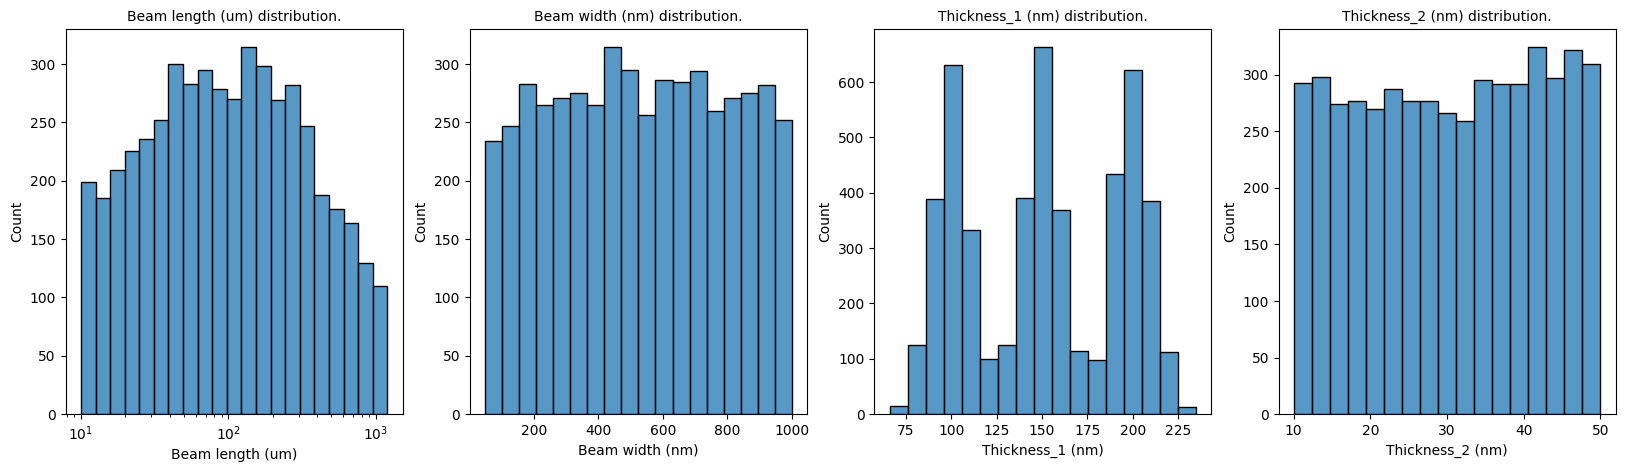

In [12]:
plot_distribution(df, indices_to_plot=[0, 1, 2, 3], col_names=col_names, log_scale=[True, False, False, False])

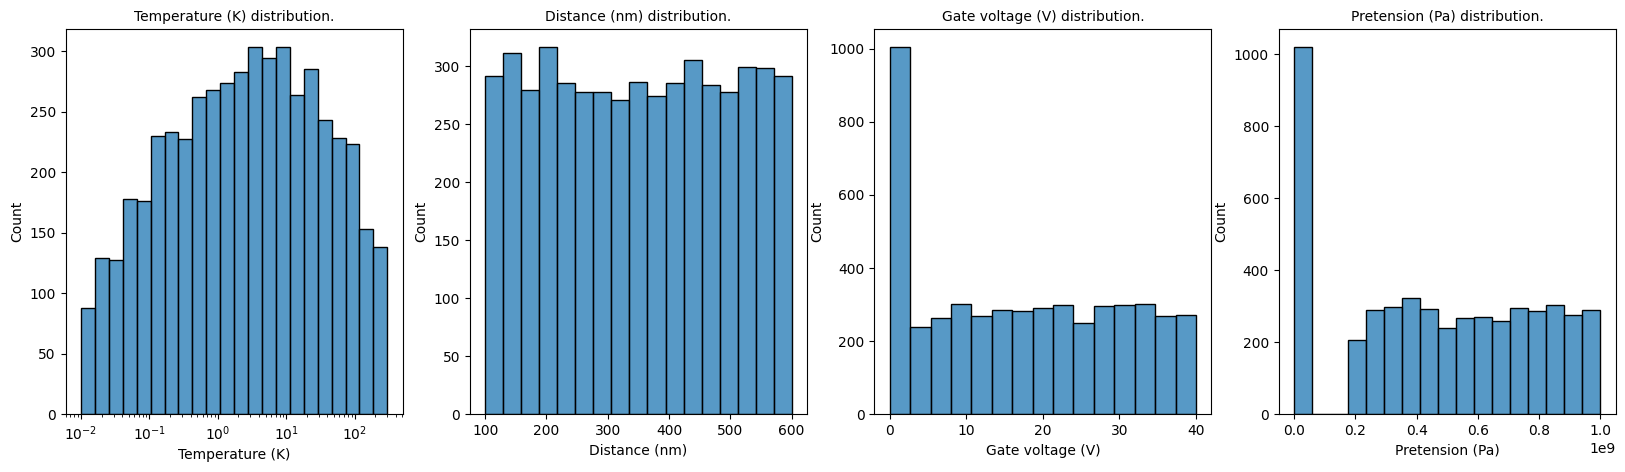

In [13]:
plot_distribution(df, indices_to_plot=[4, 5, 6, 7], col_names=col_names, log_scale=[True, False, False, False])

# Распределение выходных параметров во всем датасете для каждой моды в отдельности

Здесь приведены распределения резонансной частоты, добротности, эффективной массы и термоупругих потерь для всего датасета.

Распределение резонансных частот по модам (**atencio:** логарифмический масштаб):

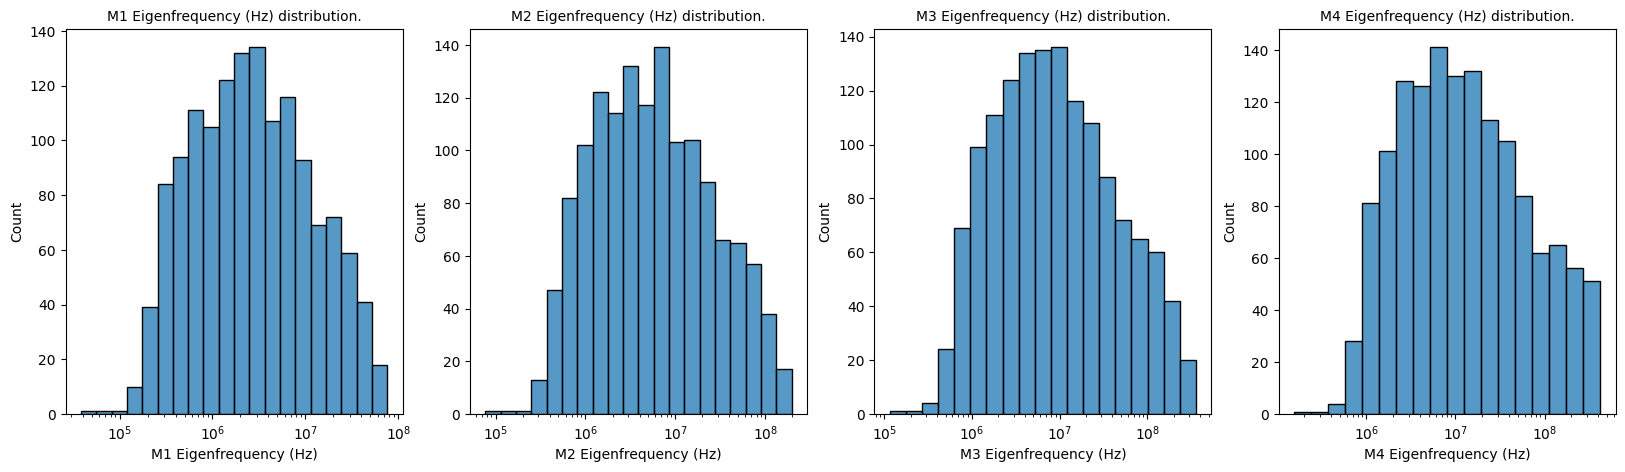

In [ ]:
plot_distribution(df, indices_to_plot=[8, 13, 18, 23], col_names=col_names, log_scale=[True, True, True, True])

__Note__: распределение при 2000 обычных конфигурациях + 1200 коротких конфигураций 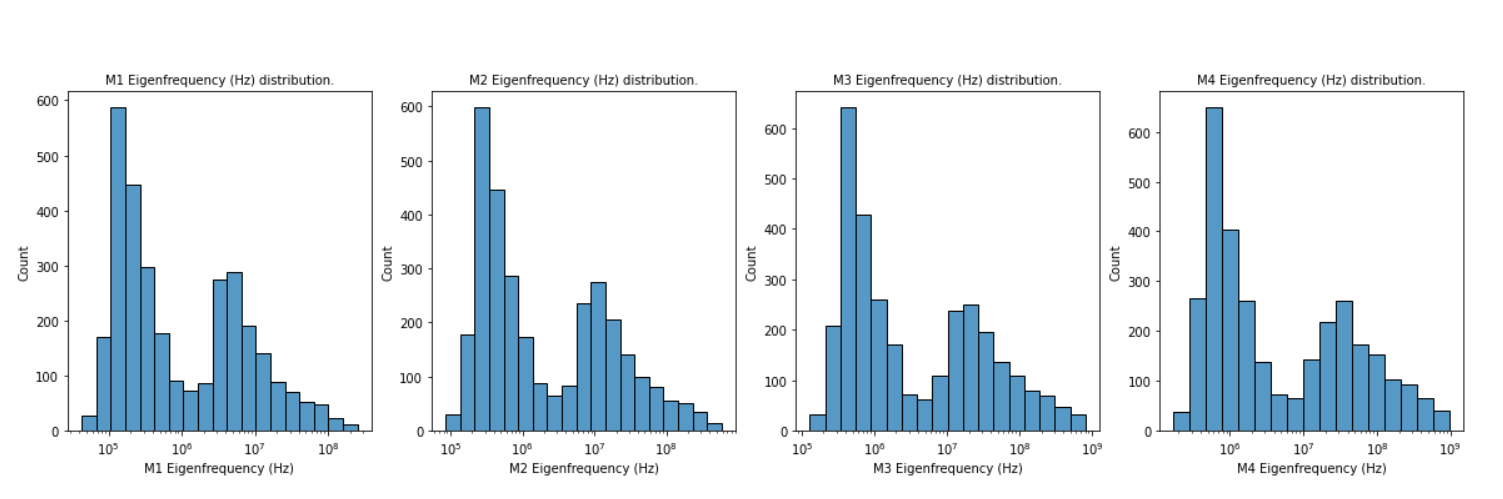

__Note__: 2000 обычных + 1200 коротких + 1200 средних
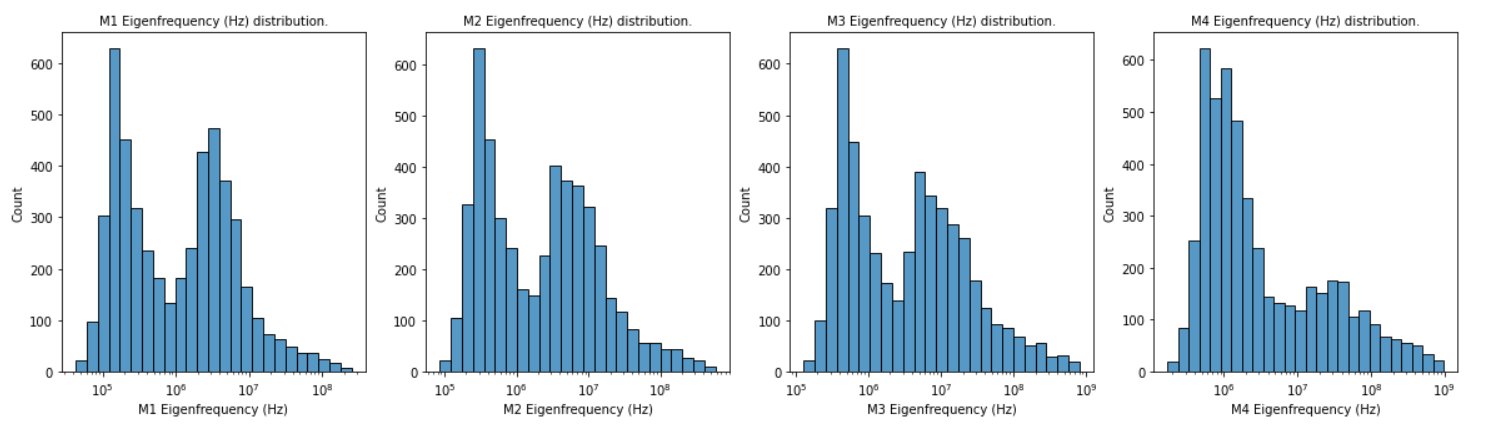

Распределение добротностей по модам. Комментарий: наблюдаем аномалию на 3-ей и 4-ой модах?

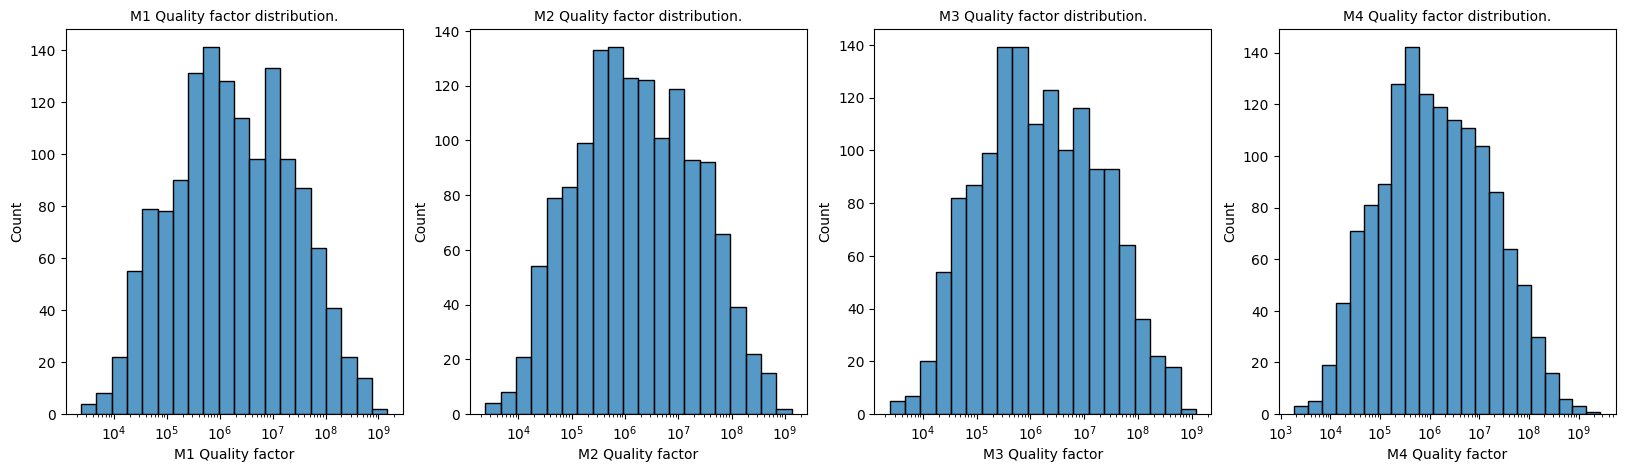

In [ ]:
plot_distribution(df, indices_to_plot=[9, 14, 19, 24], col_names=col_names, log_scale=[True, True, True, True])

Распределение эффективной массы по модам:

TypeError: ignored

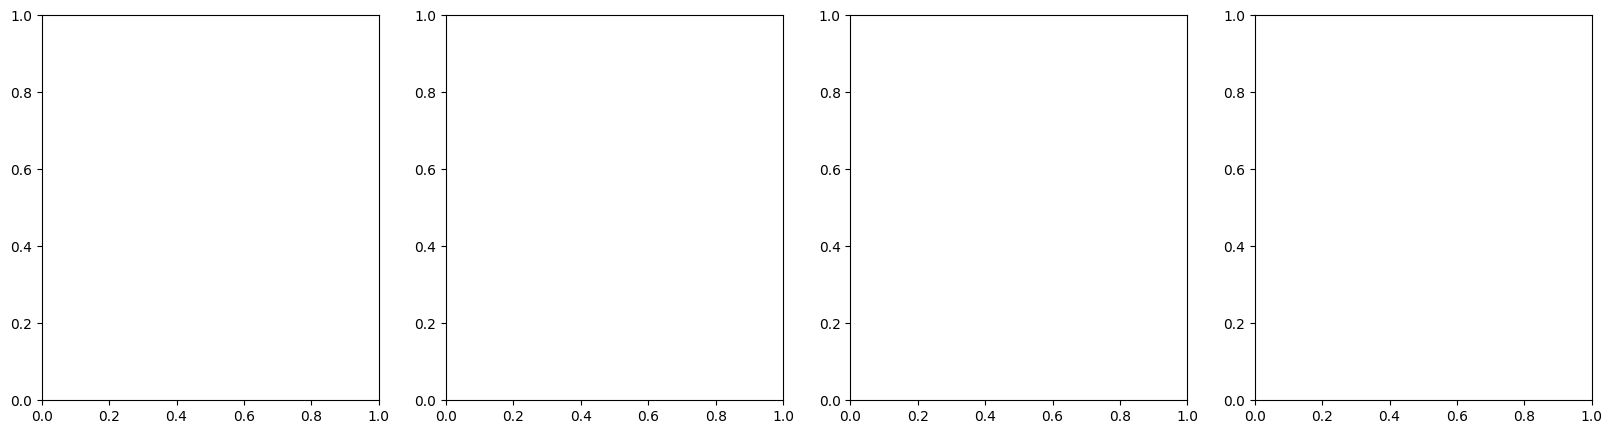

In [ ]:
plot_distribution(df, indices_to_plot=[9, 14, 19, 24], col_names=col_names, log_scale=True)

Распределение термоупругих потерь по модам:

In [ ]:
plot_distribution(df, indices_to_plot=[10, 15, 20, 25], col_names=col_names, log_scale=True)

Распределение шумов по модам:

In [ ]:
plot_distribution(df, indices_to_plot=[11, 16, 21, 26], col_names=col_names, log_scale=True)